# Evaluation example of CESNET-TimeSeries-2023-2024 dataset parts

In this example of dataset usage, we describe, based on our recommendation, a basic approach for network traffic forecasting using the CESNET-TimeSeries-2023-2024 dataset. We noted descriptions using the No., in the form of (X), as we follow our checklist of recommendations:

| **No.** | **Recommendation** |
|---------|----------------------------------------------------------------------------------------------------------------------------------------|
| (1)     | Specify which dataset(s) are used in the analysis.                                                                                     |
| (2)     | Specify the aggregation interval(s) used.                                                                                              |
| (3)     | Indicate whether the approach is multivariate or univariate.                                                                            |
| (4)     | Clearly state if not all metrics are used.                                                                                              |
| (5)     | Document all preprocessing steps, including filtering, normalization, and handling gaps in time series.                                 |
| (6)     | Ensure the training phase starts from the beginning of the dataset's time frame (2023-10-09).                                           |
| (7)     | Specify the duration of the training window.                                                                                            |
| (8)     | Define and describe the validation window if employed.                                                                                  |
| (9)     | Clearly describe the retraining process if the model is retrained during the evaluation phase.                                          |
| (10)    | Specify the forecasting horizon (length of time into the future for predictions).                                                       |
| (11)    | Clearly specify the evaluation metrics used in the article.                                                                             |
| (12)    | Provide an overall comparison across each time series using statistical distributions and aggregate statistics.                         |
| (13)    | Assess and document the computational requirements and deployability of the model.                                                      |

## Experiment setup


We use three dataset parts (1): 
- Sample IP address dataset
- Institutions dataset
- Institution subnets dataset

Moreover, we use the 1 hour aggregation of the datasets (2). We use the basic SARIMA model with an order equal to $(1, 1, 1)$ and a seasonal order equal to $(1, 1, 1, 168)$ as the forecasting model. The approach is univariate (3), and we evaluated the model on all available metrics in the selected datasets (4).

In the preprocessing step, we fill gaps (if they exist) in time series with zeros, and in the case of ratio-based metrics, we fill gaps with neutral values equal to $0.5$. We do not filter any time series, and we do not normalize the data (5). 

We trained the model on monthly data, i.e., 31 days, i.e., 744 data points (7), and then the retraining with a sliding window of 7 days was done (9). We forecast on the next 7 days, i.e., 168 data points (10). After the model is retrained, it always predicts the next 7 days (11).

## Analyze results of experiment

We used Python 3.10.12

#### Install and import libraries

In [1]:
!pip3 install seaborn==0.13.0
!pip3 install scikit-learn==1.5.0
!pip3 install pandas==2.2.2
!pip3 install numpy==1.24.4
!pip3 install matplotlib==3.8.0

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, root_mean_squared_error
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
PATH_TO_RESULTS = "../results/sarima-retraining/results/"
DATASET_VERSIONS = ["ip_addresses_sample", "institutions", "institution_subnets"]
METRICS = ['n_flows' , 'n_packets', 'n_bytes', 'sum_n_dest_asn', 'average_n_dest_asn', 'std_n_dest_asn' , 'sum_n_dest_ports', 'average_n_dest_ports', 'std_n_dest_ports', 'sum_n_dest_ip', 'average_n_dest_ip', 'std_n_dest_ip', 'tcp_udp_ratio_packets', 'tcp_udp_ratio_bytes', 'dir_ratio_packets', 'dir_ratio_bytes', 'avg_duration', 'avg_ttl']

#### Obtain the evaluation metrics

We evaluate the precision of SARIMA forecasting by using the metrics RMSE, SMAPE, and $R^2$ score applied to the predictions and corresponding observations at the same time (12). 

##### RMSE

**Root Mean Squared Error (RMSE)** is a measure of the differences between predicted and actual values. It gives an idea of how far the residuals (the differences between actual and predicted values) are from zero. The RMSE is especially useful when large errors are particularly undesirable.

The RMSE is defined as:

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

Where:
- $ n $ is the number of observations
- $ y_i $ is the actual value
- $ \hat{y}_i $ is the predicted value

Moreover for the combination of multiple RMSEs we use the weighted RMSE can be calculated using the following formula:

$$
\text{Weighted RMSE} = \sqrt{\frac{\sum_{i=1}^{n} \sigma_i^2 \cdot \text{RMSE}_i^2}{\sum_{i=1}^{n} \sigma_i^2}}
$$

where $ \sigma_i^2 $ is the variance of the true values in the $ i^{th} $ dataset, and $ \text{RMSE}_i $ is the corresponding RMSE.


##### SMAPE

**Symmetric Mean Absolute Percentage Error (SMAPE)** is an accuracy measure based on percentage errors. It is useful when you want to express errors as a percentage, and it is symmetric, meaning it treats overestimations and underestimations equally.

The SMAPE is defined as:

$$
\text{SMAPE} = \frac{100\%}{n} \sum_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{(|y_i| + |\hat{y}_i|)/2}
$$

Where:
- $ n $ is the number of observations
- $ y_i $ is the actual value
- $ \hat{y}_i $ is the predicted value

Moreover for the combination of multiple SMAPEs we use mean and standard deviation of SMAPEs and also the weighted SMAPE can be calculated using the following formula:

$$
\text{Weighted SMAPE} = \frac{\sum_{i=1}^{n} \sigma_i^2 \cdot \text{SMAPE}_i}{\sum_{i=1}^{n} \sigma_i^2}
$$

where $ \sigma_i^2 $ is the variance of the true values in the $ i^{th} $ dataset, and $ \text{SMAPE}_i $ is the corresponding SMAPE.

##### R2 score

**R-squared ($ R^2 $)** is a statistical measure that indicates how well the regression predictions approximate the actual data points. It provides the proportion of the variance in the dependent variable that is predictable from the independent variables.

The $ R^2 $ score is defined as:

$$
R^2score = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

Where:
- $ n $ is the number of observations
- $ y_i $ is the actual value
- $ \hat{y}_i $ is the predicted value
- $ \bar{y} $ is the mean of the actual values

The $ R^2 $ value ranges from 0 to 1, with 1 indicating that the model perfectly predicts the data and 0 indicating that the model does not explain any of the variance in the data.

Moreover for the combination of multiple $ R^2 $ scores we use the weighted $ R^2 $ score which can be calculated using the following formula:

$$
\text{Weighted } R^2score = \frac{\sum_{i=1}^{n} \sigma_i^2 \cdot R^2score_i}{\sum_{i=1}^{n} \sigma_i^2}
$$

where $ \sigma_i^2 $ is the variance of the true values in the $ i^{th} $ dataset, and $ R^2score_i $ is the corresponding R² score.



In [4]:
epsilon = 1e-8

smapes = {}
rmses = {}
r2_scores = {}
variances = {}

for dataset_version in DATASET_VERSIONS:
    smapes[dataset_version] = {}
    rmses[dataset_version] = {}
    r2_scores[dataset_version] = {}
    variances[dataset_version] = {}
    
    try:
        path = f"{PATH_TO_RESULTS}{dataset_version}/agg_1_hour/"
        results_institutions_files = os.listdir(path)
    except Exception as e:
        results_institutions_files = []
    
    for metric in METRICS:
        smapes[dataset_version][metric] = []
        rmses[dataset_version][metric] = []
        r2_scores[dataset_version][metric] = []
        variances[dataset_version][metric] = []
        
        for file in results_institutions_files:
            if metric in file:
                df = pd.read_csv(f"{path}{file}")
                df = df.dropna()
                
                _test = df[metric].values
                _predictions = df[f"{metric}_predictions"].values
                
                rmses[dataset_version][metric].append(root_mean_squared_error(_test, _predictions) )
                smapes[dataset_version][metric].append((2 * abs(_test - _predictions) / (abs(_test) + abs(_predictions) + epsilon)).mean() * 100) 
                r2_scores[dataset_version][metric].append(r2_score(_test, _predictions))
                variances[dataset_version][metric].append(np.var(_test))


We combine the metrics computed on individual time series using mean and standard deviation (13)

#### RMSE

Mean and standard deviation of RMSE:

In [5]:
df = {
    "metric": METRICS, 
}

for dataset_version in DATASET_VERSIONS:
    df[dataset_version] = []
    for metric in METRICS:
        s_tmp = np.array(rmses[dataset_version][metric])
        df[dataset_version].append(f"{np.mean(s_tmp):.2f} (± {np.std(s_tmp):.2f})")
pd.DataFrame(df)

,metric,ip_addresses_sample,institutions,institution_subnets
0,n_flows,4932.52 (± 136550.13),3554630.90 (± 57881635.43),164731.77 (± 3063702.19)
1,n_packets,14107339.68 (± 329492256.72),159985275.14 (± 1694780728.28),85849218.38 (± 1230153863.99)
2,n_bytes,1055898120.92 (± 17831697351.01),2173544903.14 (± 11386336162.94),362900314851.90 (± 8067819486056.84)
3,sum_n_dest_asn,11.49 (± 71.56),3119.31 (± 27752.29),7225.87 (± 114957.20)
4,average_n_dest_asn,2.03 (± 10.20),3.44 (± 4.20),1148.37 (± 26711.32)
5,std_n_dest_asn,0.78 (± 2.67),13.46 (± 91.30),8.94 (± 67.36)
6,sum_n_dest_ports,400.44 (± 8226.02),78376.30 (± 1130701.67),31313.43 (± 369823.32)
7,average_n_dest_ports,41.08 (± 656.88),62.72 (± 600.52),45.57 (± 365.98)
8,std_n_dest_ports,71.78 (± 1864.37),767.46 (± 8078.90),26987.31 (± 568200.93)
9,sum_n_dest_ip,86.91 (± 1108.90),11932.34 (± 127879.08),29728.11 (± 469831.79)


Weighted RMSE:

In [6]:
df = {
    "metric": METRICS, 
}

for dataset_version in DATASET_VERSIONS:
    df[dataset_version] = []
    for metric in METRICS:
        s_tmp = np.array(rmses[dataset_version][metric])
        v_tmp = np.array(variances[dataset_version][metric])
        
        df[dataset_version].append(
            f"{np.sqrt((s_tmp * s_tmp * v_tmp).sum() / (v_tmp).sum()):.2f}"
            )
pd.DataFrame(df)

,metric,ip_addresses_sample,institutions,institution_subnets
0,n_flows,4265978.06,4222009.64,4203601.17
1,n_packets,21175121.97,96047538.65,98648032.17
2,n_bytes,106207177099.99,41772791362.46,95764739311297.44
3,sum_n_dest_asn,1088.83,35368.26,481503.23
4,average_n_dest_asn,179.07,19.33,20527.56
5,std_n_dest_asn,45.66,204.32,209.57
6,sum_n_dest_ports,33755.75,767743.38,126322.58
7,average_n_dest_ports,6393.00,552.89,896.17
8,std_n_dest_ports,2537.64,16318.87,4837033.59
9,sum_n_dest_ip,22845.21,118293.72,120776.41


#### SMAPE

Mean and standard deviation

In [7]:
df = {
    "metric": METRICS, 
}

for dataset_version in DATASET_VERSIONS:
    df[dataset_version] = []
    for metric in METRICS:
        s_tmp = np.array(smapes[dataset_version][metric])
        df[dataset_version].append(
            f"{np.mean(s_tmp):.2f} (± {np.std(s_tmp):.2f})"
        )
pd.DataFrame(df)

,metric,ip_addresses_sample,institutions,institution_subnets
0,n_flows,141.59 (± 53.29),39.88 (± 18.19),44.87 (± 26.34)
1,n_packets,147.22 (± 50.22),83.09 (± 32.50),83.50 (± 36.78)
2,n_bytes,150.55 (± 49.40),94.46 (± 36.31),96.41 (± 41.20)
3,sum_n_dest_asn,139.48 (± 56.34),21.05 (± 13.05),28.40 (± 25.68)
4,average_n_dest_asn,136.51 (± 58.46),18.00 (± 12.05),23.57 (± 24.71)
5,std_n_dest_asn,138.27 (± 55.94),25.73 (± 16.02),31.62 (± 26.77)
6,sum_n_dest_ports,139.38 (± 54.94),33.49 (± 19.38),38.38 (± 26.91)
7,average_n_dest_ports,138.50 (± 56.31),29.82 (± 19.67),33.47 (± 26.98)
8,std_n_dest_ports,139.90 (± 53.92),50.20 (± 25.82),51.29 (± 30.56)
9,sum_n_dest_ip,140.22 (± 54.43),29.04 (± 14.79),35.53 (± 25.69)


Weighted SMAPE

In [8]:
df = {
    "metric": METRICS, 
}

for dataset_version in DATASET_VERSIONS:
    df[dataset_version] = []
    for metric in METRICS:
        s_tmp = np.array(smapes[dataset_version][metric])
        v_tmp = np.array(variances[dataset_version][metric])
        
        df[dataset_version].append(
            f"{np.sqrt((s_tmp * v_tmp).sum() / (v_tmp).sum()):.2f}"
        )
pd.DataFrame(df)

,metric,ip_addresses_sample,institutions,institution_subnets
0,n_flows,6.93,6.83,6.84
1,n_packets,7.97,6.48,7.27
2,n_bytes,8.54,6.91,7.85
3,sum_n_dest_asn,5.39,4.19,4.63
4,average_n_dest_asn,5.51,5.47,6.10
5,std_n_dest_asn,7.63,7.15,7.39
6,sum_n_dest_ports,7.33,4.80,5.40
7,average_n_dest_ports,6.78,9.76,8.45
8,std_n_dest_ports,9.41,10.04,9.86
9,sum_n_dest_ip,7.09,4.43,4.68


#### R2 score

Mean and standard deviation

In [9]:
df = {
    "metric": METRICS, 
}

for dataset_version in DATASET_VERSIONS:
    df[dataset_version] = []
    for metric in METRICS:
        s_tmp = np.array(r2_scores[dataset_version][metric])
        df[dataset_version].append(f"{np.mean(s_tmp):.2f} (± {np.std(s_tmp):.2f})")
pd.DataFrame(df)

,metric,ip_addresses_sample,institutions,institution_subnets
0,n_flows,-1723.51 (± 29097.48),-682288968.59 (± 11250645606.62),-6569892.40 (± 150354778.30)
1,n_packets,-800404133.04 (± 17920620116.94),-75843552.12 (± 1086374164.55),-39808985.42 (± 787709093.11)
2,n_bytes,-1319267.79 (± 35529451.75),-725.16 (± 12126.53),-95089400.69 (± 2192261051.32)
3,sum_n_dest_asn,-2.06 (± 44.94),-124056.52 (± 2004196.09),-102312.48 (± 2383269.05)
4,average_n_dest_asn,-10.11 (± 295.88),0.34 (± 0.97),-18027553.90 (± 420471203.86)
5,std_n_dest_asn,-0.68 (± 3.55),-95.34 (± 1225.92),-49.44 (± 883.99)
6,sum_n_dest_ports,-7405.97 (± 168175.73),-7439.18 (± 112546.98),-4601893.95 (± 104673868.08)
7,average_n_dest_ports,-131.21 (± 2734.56),-5292.06 (± 87895.92),-171.61 (± 3542.01)
8,std_n_dest_ports,-97722.33 (± 2901132.95),-9448.38 (± 144207.42),-432640.55 (± 6008659.08)
9,sum_n_dest_ip,-42724.61 (± 1257291.09),-68306.88 (± 1134805.98),-1221243.49 (± 27204647.75)


Weighted R2 score

In [10]:
df = {
    "metric": METRICS, 
}

for dataset_version in DATASET_VERSIONS:
    df[dataset_version] = []
    for metric in METRICS:
        s_tmp = np.array(r2_scores[dataset_version][metric])
        v_tmp = np.array(variances[dataset_version][metric])
        
        df[dataset_version].append(
            f"{(s_tmp * v_tmp).sum() / (v_tmp).sum():.2f}"
        )
pd.DataFrame(df)

,metric,ip_addresses_sample,institutions,institution_subnets
0,n_flows,0.11,-43392.01,-233.81
1,n_packets,-2637099.26,-122567.94,-133636.34
2,n_bytes,-15486.36,-3.54,-4469099.57
3,sum_n_dest_asn,-0.12,-11.91,-569.54
4,average_n_dest_asn,0.08,0.23,-10627084.95
5,std_n_dest_asn,-0.22,-60.98,-32.77
6,sum_n_dest_ports,-17.59,-3057.95,-696.44
7,average_n_dest_ports,-3.73,-85.75,-23.13
8,std_n_dest_ports,-1394.60,-2712.46,-14921919.69
9,sum_n_dest_ip,0.07,-38.00,-1148.32


### Evaluation using histograms

#### SMAPE


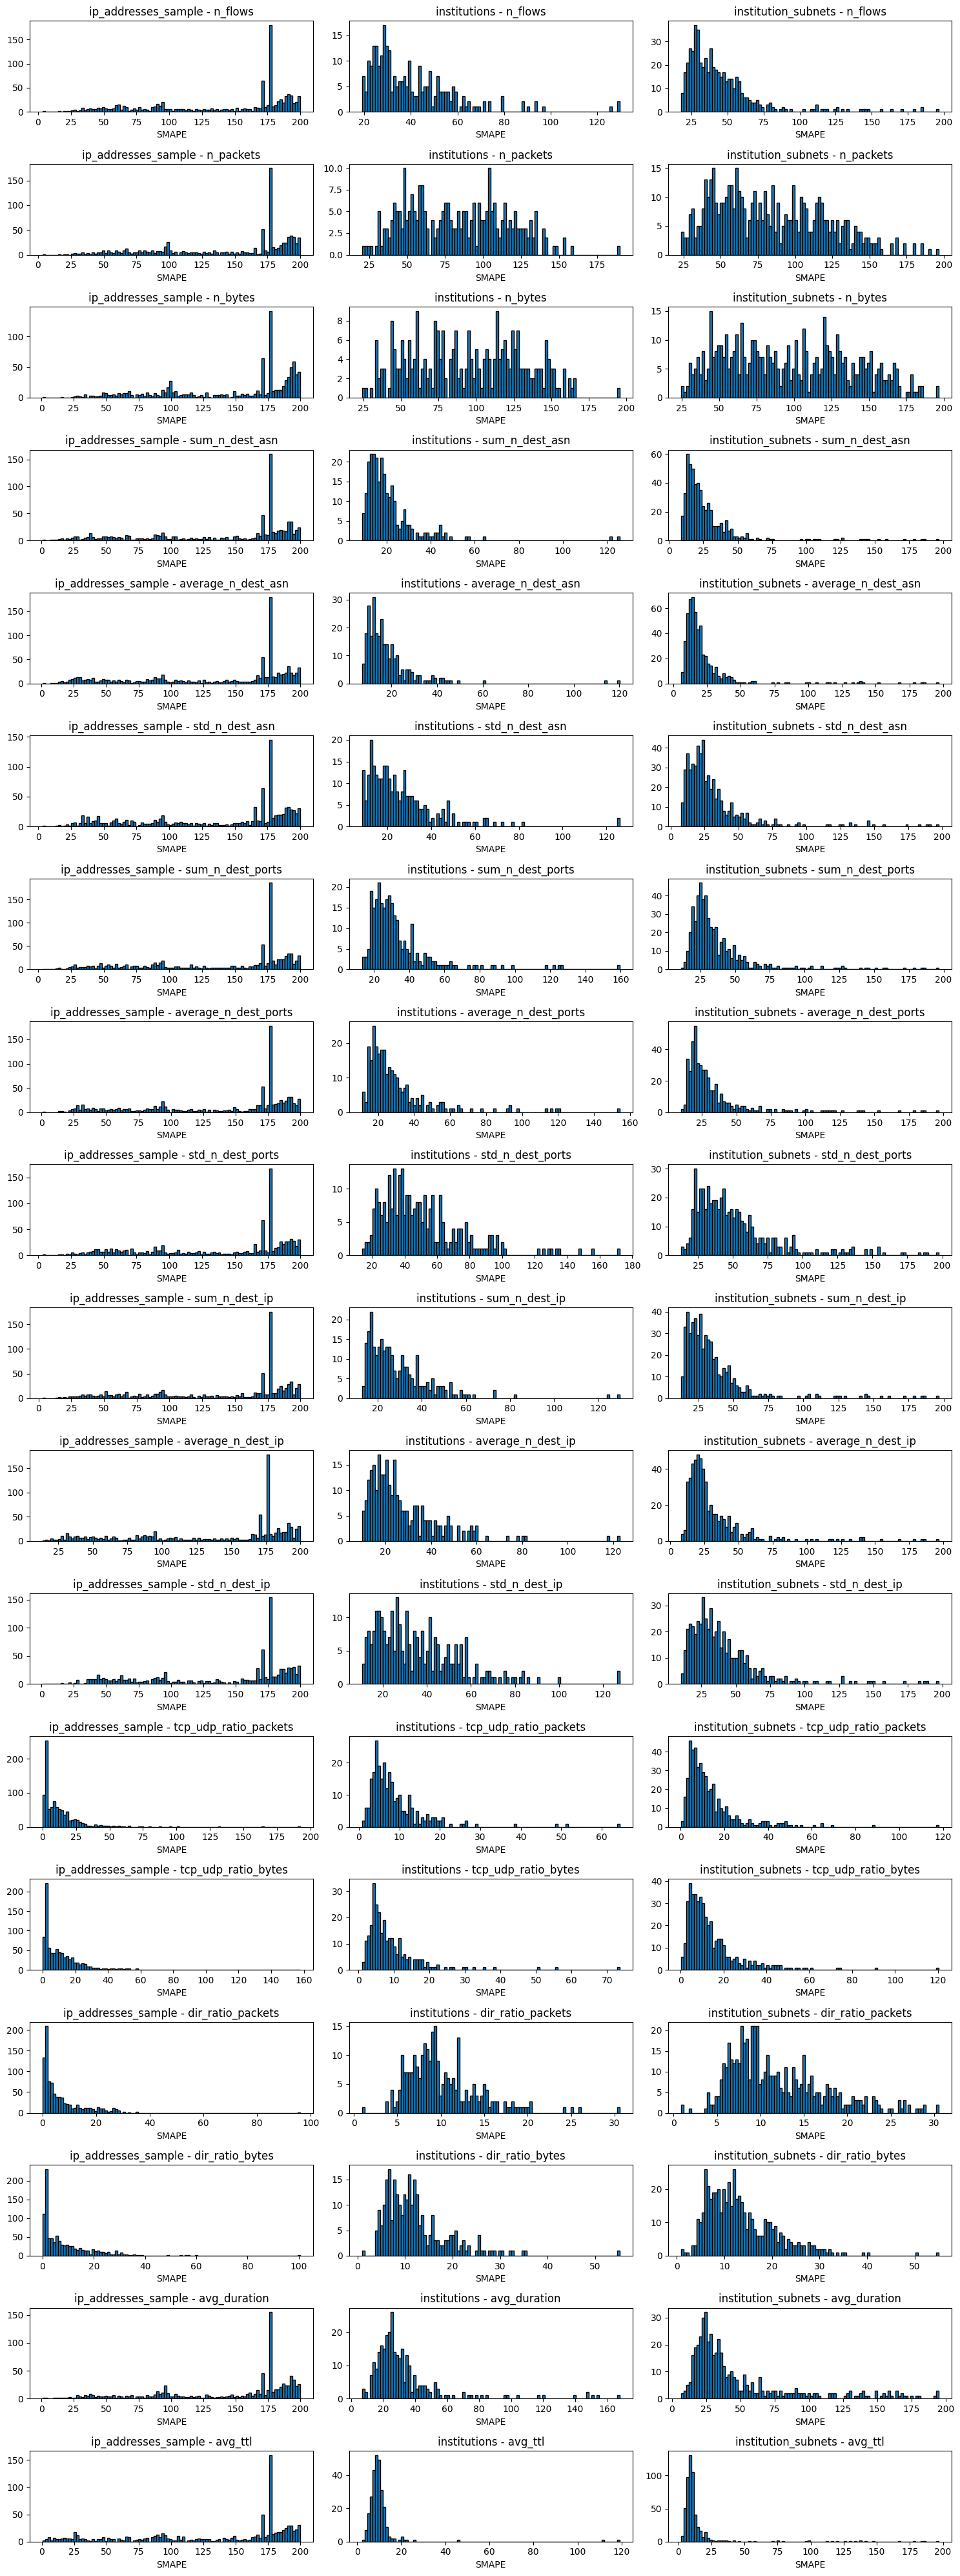

In [12]:
fig, axs = plt.subplots(len(METRICS), len(DATASET_VERSIONS), figsize=(15,40))
i = 0
for metric in METRICS:
    j = 0
    tmp = metric.replace("_", "\_")
    for dataset_version in DATASET_VERSIONS:
        axs[i][j].hist(smapes[dataset_version][metric], bins=100, edgecolor='black')
        axs[i][j].set_title(f"{dataset_version} - {metric}")
        axs[i][j].set_xlabel("SMAPE")
        j += 1
    i += 1
        

plt.tight_layout()
plt.show()

### Evaluation using KDE plots

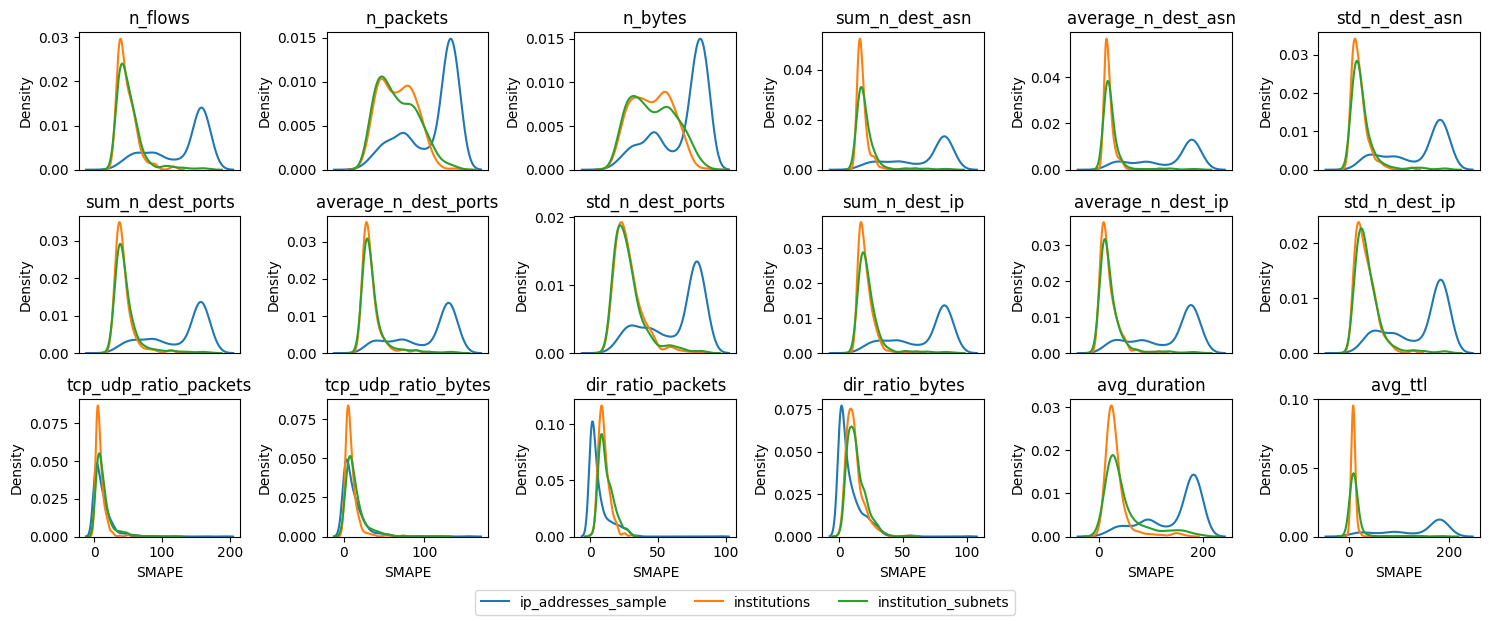

In [17]:
fig, axs = plt.subplots(3, 6,  figsize=(15, 6))

i = 0
j = 0
for metric in METRICS:
    ax = axs[i][j]
    tmp = metric.replace("_", "\_")
    for dataset_version in DATASET_VERSIONS:
        sns.kdeplot(smapes[dataset_version][metric], ax=ax, shade=False, label=dataset_version)
    
    if i == 2:
        ax.set_xlabel("SMAPE")
    else:
        ax.set_xticks([])
    
    ax.set_title(metric)
    
    j += 1
    if j == 6:
        j = 0 
        i += 1

# Create a common legend for all subplots
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=len(DATASET_VERSIONS))

plt.tight_layout()

plt.show()